In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from itertools import product
from math import log

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

import altair as alt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

from statsmodels.tsa.seasonal import seasonal_decompose, STL

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max.columns', None)
pd.set_option('display.max.rows', None)

# Завантаження та підготовка даних

In [3]:
df_nflx = pd.read_csv('NFLX.csv')

In [4]:
df_nflx.head()

,Date,Open,High,Low,Close,Volume
0,2016-02-11,87.419998,88.389999,82.910004,86.349998,21820300
1,2016-02-12,86.639999,89.720001,85.260002,87.400002,19067700
2,2016-02-16,89.000000,90.139999,87.540001,89.050003,16356600
3,2016-02-17,90.129997,94.769997,89.639999,94.760002,18323800
4,2016-02-18,94.800003,94.900002,90.309998,90.489998,17695300


In [5]:
def prepare_dataset(df_nflx):
    df_nflx['Date'] = pd.to_datetime(df_nflx['Date'])
    df_nflx['Date_index'] = pd.DatetimeIndex(df_nflx['Date']) 
    
    data_no_missing = df_nflx.copy(deep=True)

    data_no_missing = data_no_missing.set_index('Date_index').asfreq('D')

    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        data_no_missing[col] = data_no_missing[col].interpolate()

    data_no_missing = data_no_missing.reset_index(drop=False)

    data_no_missing['Date'] = pd.to_datetime(data_no_missing['Date_index']).dt.date
    data_no_missing['year'] = pd.to_datetime(data_no_missing['Date']).dt.year
    data_no_missing['quarter'] = pd.to_datetime(data_no_missing['Date']).dt.quarter
    data_no_missing['month'] = pd.to_datetime(data_no_missing['Date']).dt.month
    
    return df_nflx, data_no_missing

In [6]:
df_nflx, data_no_missing = prepare_dataset(df_nflx)

In [7]:
df_nflx.head()

,Date,Open,High,Low,Close,Volume,Date_index
0,2016-02-11,87.419998,88.389999,82.910004,86.349998,21820300,2016-02-11
1,2016-02-12,86.639999,89.720001,85.260002,87.400002,19067700,2016-02-12
2,2016-02-16,89.000000,90.139999,87.540001,89.050003,16356600,2016-02-16
3,2016-02-17,90.129997,94.769997,89.639999,94.760002,18323800,2016-02-17
4,2016-02-18,94.800003,94.900002,90.309998,90.489998,17695300,2016-02-18


In [8]:
data_no_missing.head()

,Date_index,Date,Open,High,Low,Close,Volume,year,quarter,month
0,2016-02-11,2016-02-11,87.419998,88.389999,82.910004,86.349998,21820300.0,2016,1,2
1,2016-02-12,2016-02-12,86.639999,89.720001,85.260002,87.400002,19067700.0,2016,1,2
2,2016-02-13,2016-02-13,87.229999,89.825001,85.830002,87.812502,18389925.0,2016,1,2
3,2016-02-14,2016-02-14,87.819999,89.930000,86.400002,88.225003,17712150.0,2016,1,2
4,2016-02-15,2016-02-15,88.410000,90.034999,86.970001,88.637503,17034375.0,2016,1,2


## Перевірка на стаціонарність

In [9]:
def stationarity_test(ts, stat_test):
    result = stat_test(ts)
    test_name = stat_test.__name__
    
    test_result = {
        test_name + "_statistics": result[0],
        test_name + "_p_value": result[1],
        test_name + "_critical_values": result[4] if test_name == 'adfuller' else result[3] if test_name == 'kpss' else None
    }
    
    return test_result

### Тест Дікі-Фулера

In [10]:
stationarity_test(data_no_missing['Close'], smt.adfuller)

{'adfuller_statistics': -0.1770206363229292,
 'adfuller_p_value': 0.9412058403227873,
 'adfuller_critical_values': {'1%': -3.433976034843506,
  '5%': -2.8631416925158244,
  '10%': -2.5676226884667694}}

### KPSS тест

In [11]:
stationarity_test(data_no_missing['Close'], smt.kpss)

{'kpss_statistics': 6.214577387345509,
 'kpss_p_value': 0.01,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

### Можемо зробити висновок, що вихідний часовий ряд не є стаціонарним

In [12]:
data_no_missing.head(1)

,Date_index,Date,Open,High,Low,Close,Volume,year,quarter,month
0,2016-02-11,2016-02-11,87.419998,88.389999,82.910004,86.349998,21820300.0,2016,1,2


## Основні функції 

In [13]:
def plot_real_predict_ts(stationary_ts, fitted_values, figsize=(8, 10)):
    stationary_ts.plot(figsize=figsize, color = 'black', alpha = .6);
    fitted_values.plot(figsize=figsize, color = 'red', alpha = .6);
    plt.legend(['Real time serie', 'Predicted time serie']);
    plt.title('Real and Predicted values for given time series');

In [14]:
def get_predictions(arima_model, test_size, train=True):
    if train:
        preds = pd.Series(arima_model.fittedvalues, copy=True)
    else:
        preds = pd.Series(arima_model.forecast(steps=test_size).values, copy=True)
    
    return preds

In [15]:
LIST_METRICS = [lambda real, predictions: np.sqrt(sum((predictions - real.values) ** 2) / len(real)),
                lambda real, predictions: sum((predictions - real.values) ** 2), mean_squared_error,
                mean_absolute_error, lambda real, predictions: np.mean(np.abs((real - predictions) / real)),
                r2_score
               ]

TITLE_METRICS = ['RMSE', 'RSS', 'MSE', 'MAE', 'MAPE', 'R2']

In [16]:
QTY_SPLITS = 3

In [17]:
def akaike_criterion(n, mse, num_params):
    return n * log(mse) + 2 * num_params


def bayess_criterion(n, mse, num_params):
    return n * log(mse) + num_params * log(n)

In [18]:
# використовуємо порядок ARMA, знайдений у першій частині
D_ORDERS_RANGE = range(6)
P_ORDERS_RANGE = [4] * len(D_ORDERS_RANGE)
Q_ORDERS_RANGE = [5] * len(D_ORDERS_RANGE)

In [19]:
INDEX = pd.MultiIndex.from_product((P_ORDERS_RANGE, D_ORDERS_RANGE, Q_ORDERS_RANGE, list(range(QTY_SPLITS))))

In [20]:
INDEX = pd.MultiIndex.from_tuples(list(set(INDEX)), names=['P', 'D', 'Q', 'Fold number'])

In [21]:
def calc_metrics(df, predictions, ar_model_fitted, target_column='Close', metrics_list=LIST_METRICS,
                 titles_list=TITLE_METRICS
                ):
    
    metrics_df = pd.DataFrame()
    
    for metric, title in zip(metrics_list, titles_list):
        calculated_metric = metric(np.log(df[target_column]), predictions)
        metrics_df.loc[0, title] = calculated_metric
    
    metrics_df['AIC'] = akaike_criterion(df.shape[0], mean_squared_error(df[target_column], predictions),
                                         ar_model_fitted.params.shape[0]
                                        )

    metrics_df['BIC'] = bayess_criterion(df.shape[0], mean_squared_error(df[target_column], predictions),
                                         ar_model_fitted.params.shape[0]
                                        )
    
    return metrics_df

In [22]:
def make_models_range(p, d, q, train_df_tmp, test_df_tmp, metrics_list=LIST_METRICS,
                      titles_list=TITLE_METRICS, target_column='Close'
                     ):
    
    arima_model = ARIMA(np.log(train_df_tmp[target_column]), order=(p, d, q))
    arima_model_fitted = arima_model.fit()
    
    arima_predictions = get_predictions(arima_model_fitted, train_df_tmp.shape[0])
    arima_predictions_test = get_predictions(arima_model_fitted, test_df_tmp.shape[0], False)
        
    train_metrics_df_arima = calc_metrics(train_df_tmp, arima_predictions, arima_model_fitted)
    test_metrics_df_arima = calc_metrics(test_df_tmp, arima_predictions_test, arima_model_fitted)
    
    return train_metrics_df_arima, test_metrics_df_arima

## Розбиття часового ряду на train / validation 

In [23]:
ts = data_no_missing['Close']

folds_indexes = list(TimeSeriesSplit(n_splits=QTY_SPLITS, test_size=200).split(ts))
min_fold_len = min([len(fold[0]) for fold in folds_indexes])

for i in range(len(folds_indexes)):
    folds_indexes[i] = (folds_indexes[i][0][-min_fold_len:], folds_indexes[i][1])

### Графік розбиття часового ряду на train/ validation для 1-го фолда 

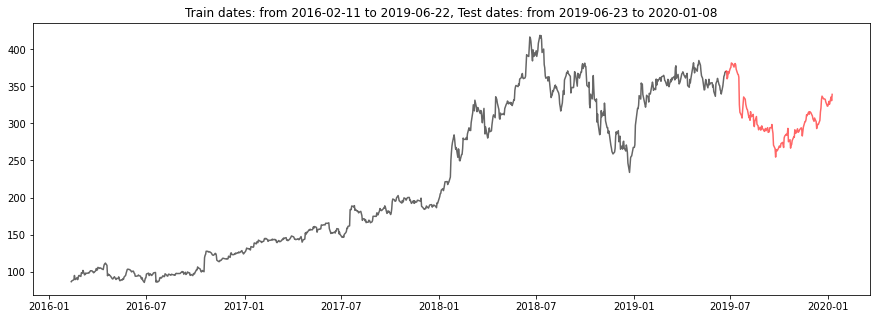

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

train_df_tmp_first = data_no_missing.loc[folds_indexes[0][0], :]
validate_df_tmp_first = data_no_missing.loc[folds_indexes[0][1], :]

plt.plot(
    train_df_tmp_first['Date'],  train_df_tmp_first['Close'], "black", alpha = .6 
)
plt.plot(
    validate_df_tmp_first['Date'],  validate_df_tmp_first['Close'], "red", alpha = .6 
)
plt.title('Train dates: from {} to {}, Test dates: from {} to {}'.format(
    train_df_tmp_first.Date.min(), train_df_tmp_first.Date.max(), validate_df_tmp_first.Date.min(), 
    validate_df_tmp_first.Date.max()));

## Побудова першого фолда

In [25]:
train_indexes = folds_indexes[0][0]
test_indexes = folds_indexes[0][1]

train_df_tmp_first = data_no_missing.loc[train_indexes, :]
test_df_tmp_first = data_no_missing.loc[test_indexes, :]

## Побудова моделей для різних порядків

In [26]:
train_metrics_df_first_fold = pd.DataFrame()
test_metrics_df_first_fold = pd.DataFrame()

In [27]:
for p, d, q in zip(P_ORDERS_RANGE, D_ORDERS_RANGE, Q_ORDERS_RANGE):
    train_metrics_df_arima, test_metrics_df_arima = make_models_range(p, d, q, train_df_tmp_first,
                                                                      test_df_tmp_first
                                                                     )
    
    train_metrics_df_first_fold = pd.concat((train_metrics_df_first_fold, train_metrics_df_arima))
    test_metrics_df_first_fold = pd.concat((test_metrics_df_first_fold, test_metrics_df_arima))

In [28]:
train_metrics_df_first_fold.shape

(6, 8)

In [29]:
train_metrics_df_first_fold

,RMSE,RSS,MSE,MAE,MAPE,R2,AIC,BIC
0,0.029421,1.062955,0.000866,0.012060,0.002311,0.996599,13469.845366,13526.089929
0,0.128588,20.304959,0.016535,0.015036,0.002978,0.935032,13467.860031,13518.991452
0,0.143343,25.232042,0.020547,0.017175,0.003445,0.919267,13467.842534,13518.973955
0,0.181910,40.636208,0.033091,0.019978,0.004063,0.869980,13467.841091,13518.972512
0,0.238785,70.018403,0.057018,0.025431,0.005214,0.775968,13467.837123,13518.968544
0,0.313235,120.486662,0.098116,0.033939,0.006981,0.614489,13467.836392,13518.967813


In [30]:
test_metrics_df_first_fold

,RMSE,RSS,MSE,MAE,MAPE,R2,AIC,BIC
0,0.179277,6.428026e+00,0.032140,0.157828,NaN,-2.520194e+00,2309.325383,2345.606874
0,0.209367,8.766921e+00,0.043835,0.188983,NaN,-3.801048e+00,2307.284750,2340.267924
0,0.279541,1.562868e+01,0.078143,0.256319,NaN,-7.558770e+00,2307.197000,2340.180173
0,0.575311,6.619644e+01,0.330982,0.522415,NaN,-3.525130e+01,2306.854219,2339.837392
0,1.132688,2.565966e+02,1.282983,0.964443,NaN,-1.395206e+02,2306.281962,2339.265136
0,684.308766,9.365570e+07,468278.487751,418.023662,NaN,-5.128887e+07,2742.632313,2775.615487


### Графік розбиття часового ряду на train/ validation для 2-го фолда 

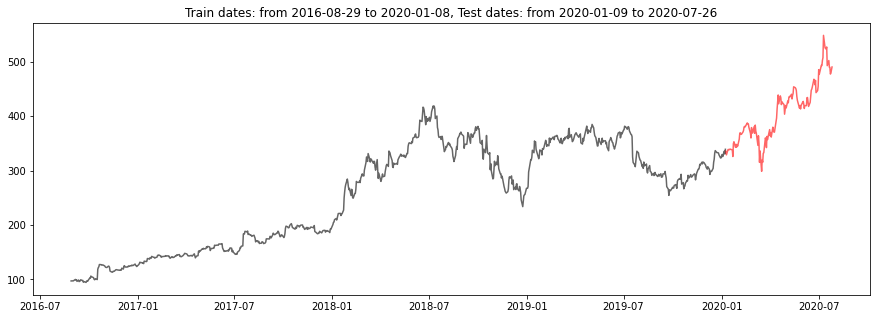

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

train_df_tmp_second = data_no_missing.loc[folds_indexes[1][0], :]
validate_df_tmp_second = data_no_missing.loc[folds_indexes[1][1], :]

plt.plot(
    train_df_tmp_second['Date'],  train_df_tmp_second['Close'], "black", alpha = .6 
)
plt.plot(
    validate_df_tmp_second['Date'],  validate_df_tmp_second['Close'], "red", alpha = .6 
)
plt.title('Train dates: from {} to {}, Test dates: from {} to {}'.format(
    train_df_tmp_second.Date.min(), train_df_tmp_second.Date.max(), validate_df_tmp_second.Date.min(),
    validate_df_tmp_second.Date.max()));

## Побудова 2-го фолда

In [32]:
train_indexes = folds_indexes[1][0]
test_indexes = folds_indexes[1][1]

train_df_tmp_second = data_no_missing.loc[train_indexes, :]
test_df_tmp_second = data_no_missing.loc[test_indexes, :]

## Побудова моделей для різних порядків

In [33]:
train_metrics_df_second_fold = pd.DataFrame()
test_metrics_df_second_fold = pd.DataFrame()

In [34]:
for p, d, q in zip(P_ORDERS_RANGE, D_ORDERS_RANGE, Q_ORDERS_RANGE):
    train_metrics_df_arima, test_metrics_df_arima = make_models_range(p, d, q, train_df_tmp_second,
                                                                      test_df_tmp_second
                                                                     )
    
    train_metrics_df_second_fold = pd.concat((train_metrics_df_second_fold, train_metrics_df_arima))
    test_metrics_df_second_fold = pd.concat((test_metrics_df_second_fold, test_metrics_df_arima))

In [35]:
train_metrics_df_second_fold

,RMSE,RSS,MSE,MAE,MAPE,R2,AIC,BIC
0,0.028162,0.973927,0.000793,0.011759,0.002162,0.995334,13735.096347,13791.340911
0,0.131859,21.351097,0.017387,0.014865,0.002841,0.897701,13733.108633,13784.240054
0,0.147146,26.588428,0.021652,0.016986,0.003295,0.872608,13733.093724,13784.225145
0,0.186886,42.889463,0.034926,0.019766,0.003894,0.794505,13733.092161,13784.223582
0,0.245376,73.937374,0.060210,0.025300,0.005025,0.645747,13733.089874,13784.221295
0,0.321694,127.082372,0.103487,0.030113,0.006061,0.391115,13733.089073,13784.220494


### Графік розбиття часового ряду на train/ validation для 3-го фолда 

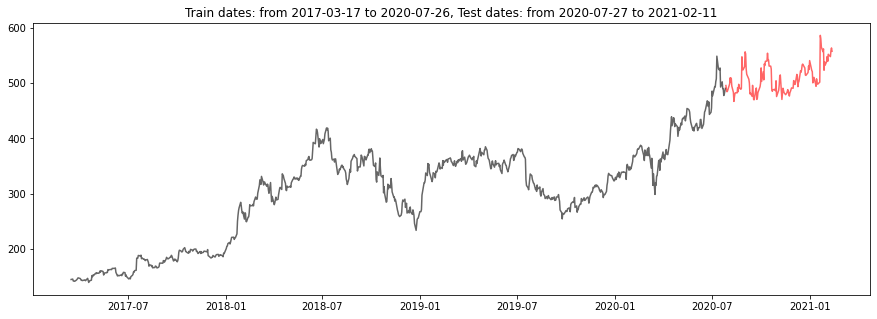

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

train_df_tmp_third = data_no_missing.loc[folds_indexes[2][0], :]
validate_df_tmp_third = data_no_missing.loc[folds_indexes[2][1], :]

plt.plot(
    train_df_tmp_third['Date'],  train_df_tmp_third['Close'], "black", alpha = .6 
)
plt.plot(
    validate_df_tmp_third['Date'],  validate_df_tmp_third['Close'], "red", alpha = .6 
)
plt.title('Train dates: from {} to {}, Test dates: from {} to {}'.format(
    train_df_tmp_third.Date.min(), train_df_tmp_third.Date.max(), validate_df_tmp_third.Date.min(),
    validate_df_tmp_third.Date.max()));

## Побудова 3-го фолда

In [37]:
train_indexes = folds_indexes[2][0]
test_indexes = folds_indexes[2][1]

train_df_tmp_third = data_no_missing.loc[train_indexes, :]
test_df_tmp_third = data_no_missing.loc[test_indexes, :]

## Побудова моделей для різних порядків

In [38]:
train_metrics_df_third_fold = pd.DataFrame()
test_metrics_df_third_fold = pd.DataFrame()

In [39]:
for p, d, q in zip(P_ORDERS_RANGE, D_ORDERS_RANGE, Q_ORDERS_RANGE):
    train_metrics_df_arima, test_metrics_df_arima = make_models_range(p, d, q, train_df_tmp_third,
                                                                      test_df_tmp_third
                                                                     )
    
    train_metrics_df_third_fold = pd.concat((train_metrics_df_third_fold, train_metrics_df_arima))
    test_metrics_df_third_fold = pd.concat((test_metrics_df_third_fold, test_metrics_df_arima))

In [40]:
train_metrics_df_third_fold.head()

,RMSE,RSS,MSE,MAE,MAPE,R2,AIC,BIC
0,0.026676,0.873886,0.000712,0.012895,0.002281,0.993317,14096.741381,14152.985944
0,0.143299,25.216428,0.020535,0.016408,0.002987,0.807168,14094.756623,14145.888044
0,0.159923,31.406591,0.025575,0.018608,0.003425,0.759832,14094.743309,14145.874730
0,0.203158,50.683352,0.041273,0.021673,0.004033,0.612421,14094.736880,14145.868301
0,0.266785,87.401820,0.071174,0.027564,0.005160,0.331633,14094.734627,14145.866048


In [41]:
all_train_metrics = pd.concat((train_metrics_df_first_fold, train_metrics_df_second_fold,
                               train_metrics_df_third_fold)
                             )

In [42]:
all_test_metrics = pd.concat((test_metrics_df_first_fold, test_metrics_df_second_fold,
                               test_metrics_df_third_fold)
                             )

In [43]:
all_test_metrics.head(1)

,RMSE,RSS,MSE,MAE,MAPE,R2,AIC,BIC
0,0.179277,6.428026,0.03214,0.157828,NaN,-2.520194,2309.325383,2345.606874


In [44]:
all_test_metrics = all_test_metrics.drop_duplicates()
all_train_metrics = all_train_metrics.drop_duplicates()

In [45]:
all_test_metrics.shape, all_train_metrics.shape, len(INDEX)

((18, 8), (18, 8), 18)

In [46]:
all_train_metrics.index = INDEX
all_test_metrics.index = INDEX

In [47]:
all_train_metrics = all_train_metrics.sort_index()
all_test_metrics = all_test_metrics.sort_index()

In [48]:
all_train_metrics.head()

RMSE         RSS       MSE       MAE      MAPE  \
P D Q Fold number                                                       
4 0 5 0            0.313235  120.486662  0.098116  0.033939  0.006981   
      1            0.029421    1.062955  0.000866  0.012060  0.002311   
      2            0.186886   42.889463  0.034926  0.019766  0.003894   
  1 5 0            0.143299   25.216428  0.020535  0.016408  0.002987   
      1            0.131859   21.351097  0.017387  0.014865  0.002841   

                         R2           AIC           BIC  
P D Q Fold number                                        
4 0 5 0            0.614489  13467.836392  13518.967813  
      1            0.996599  13469.845366  13526.089929  
      2            0.794505  13733.092161  13784.223582  
  1 5 0            0.807168  14094.756623  14145.888044  
      1            0.897701  13733.108633  13784.240054

In [49]:
all_test_metrics.head()

RMSE           RSS            MSE         MAE  MAPE  \
P D Q Fold number                                                              
4 0 5 0            684.308766  9.365570e+07  468278.487751  418.023662   NaN   
      1              0.179277  6.428026e+00       0.032140    0.157828   NaN   
      2              0.150696  4.541829e+00       0.022709    0.127975   NaN   
  1 5 0              0.057804  6.682671e-01       0.003341    0.043735   NaN   
      1              0.211347  8.933532e+00       0.044668    0.173230   NaN   

                             R2          AIC          BIC  
P D Q Fold number                                          
4 0 5 0           -5.128887e+07  2742.632313  2775.615487  
      1           -2.520194e+00  2309.325383  2345.606874  
      2           -3.179114e-01  2420.080663  2453.063837  
  1 5 0           -3.854007e-01  2507.967246  2540.950419  
      1           -1.592260e+00  2420.388548  2453.371721

In [50]:
all_train_metrics.to_csv('all_train_metrics_arima.csv', index=True)
all_test_metrics.to_csv('all_test_metrics_arima.csv', index=True)

### Графічне відображення основних метрик (усереднених по фолдам для кожного з наборів порядків моедлі) для тренувальної та тестової вибірки

#### Навчальна вибірка

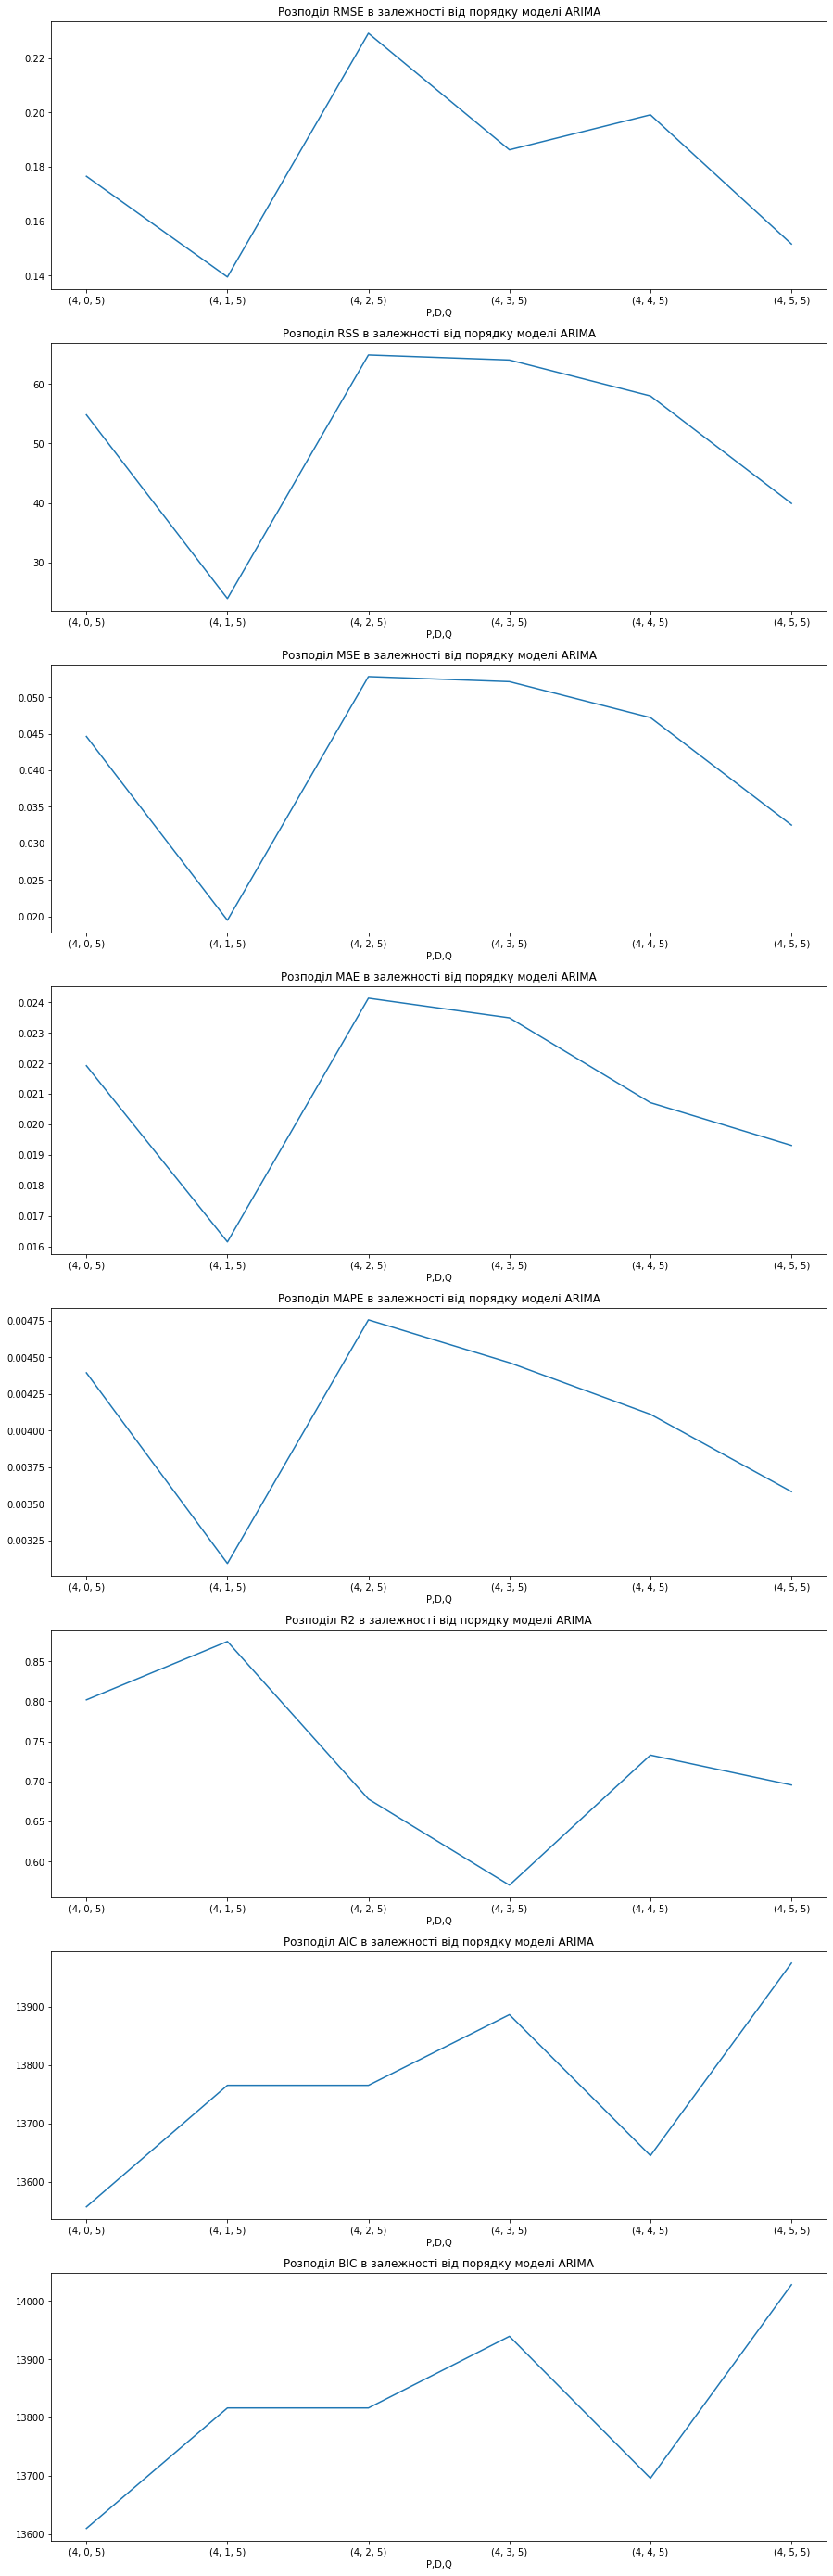

In [51]:
fig, axs = plt.subplots(nrows=all_train_metrics.shape[1], ncols=1, figsize=(15, 50))

for idx, metric_title in enumerate(all_train_metrics.columns):
    all_train_metrics.reset_index().groupby(['P', 'D', 'Q'])[metric_title].mean().plot(
        title='Розподіл {} в залежності від порядку моделі ARIMA'.format(metric_title), ax=axs[idx]);

#### Тестувальна вибірка

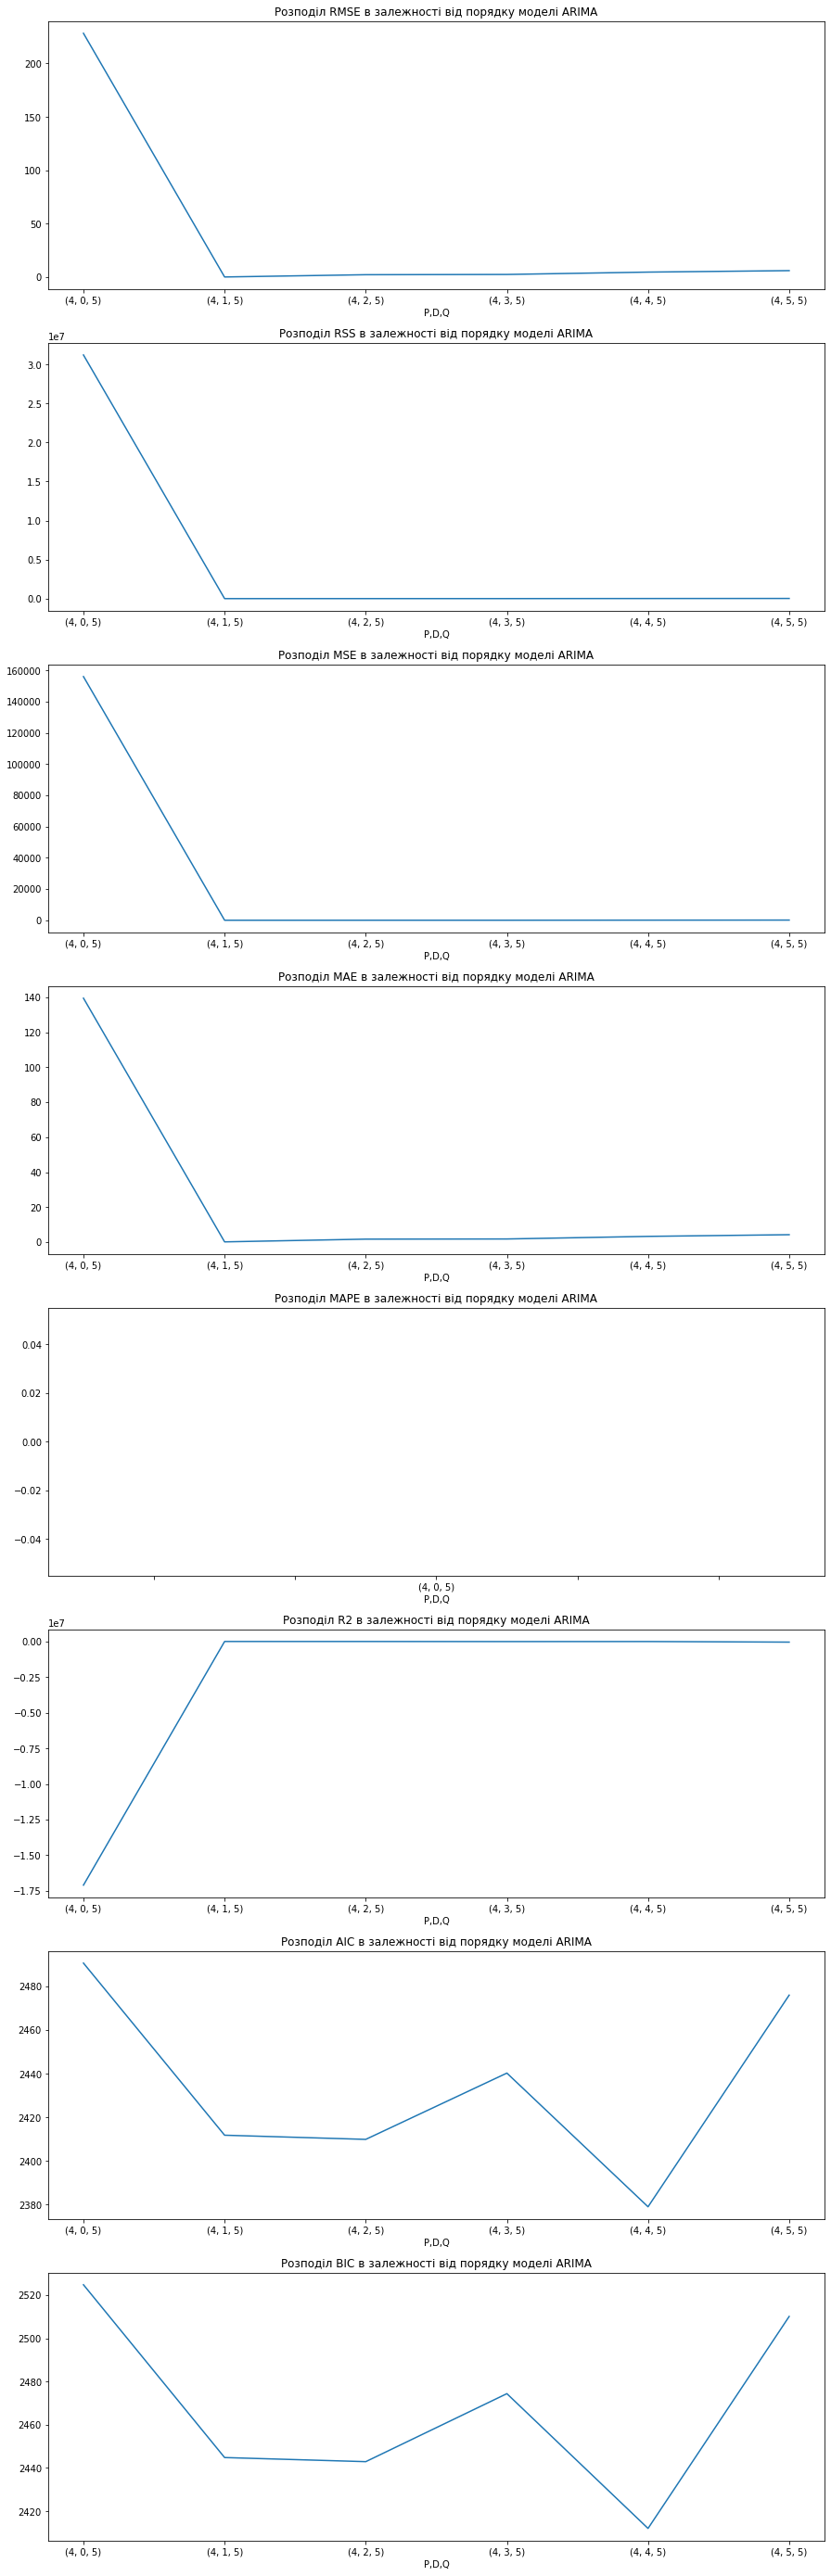

In [52]:
fig, axs = plt.subplots(nrows=all_test_metrics.shape[1], ncols=1, figsize=(15, 50))

for idx, metric_title in enumerate(all_test_metrics.columns):
    all_test_metrics.reset_index().groupby(['P', 'D', 'Q'])[metric_title].mean().plot(
        title='Розподіл {} в залежності від порядку моделі ARIMA'.format(metric_title), ax=axs[idx]);

### Повний вивід метрик

In [53]:
# розмір датафреймів по всім комбінаціям та фолдам дуже великий, тому усереднюємо метрики по фолдам
all_train_metrics.shape, all_test_metrics.shape

((18, 8), (18, 8))

In [54]:
all_train_metrics.head()

RMSE         RSS       MSE       MAE      MAPE  \
P D Q Fold number                                                       
4 0 5 0            0.313235  120.486662  0.098116  0.033939  0.006981   
      1            0.029421    1.062955  0.000866  0.012060  0.002311   
      2            0.186886   42.889463  0.034926  0.019766  0.003894   
  1 5 0            0.143299   25.216428  0.020535  0.016408  0.002987   
      1            0.131859   21.351097  0.017387  0.014865  0.002841   

                         R2           AIC           BIC  
P D Q Fold number                                        
4 0 5 0            0.614489  13467.836392  13518.967813  
      1            0.996599  13469.845366  13526.089929  
      2            0.794505  13733.092161  13784.223582  
  1 5 0            0.807168  14094.756623  14145.888044  
      1            0.897701  13733.108633  13784.240054

In [55]:
all_test_metrics.head()

RMSE           RSS            MSE         MAE  MAPE  \
P D Q Fold number                                                              
4 0 5 0            684.308766  9.365570e+07  468278.487751  418.023662   NaN   
      1              0.179277  6.428026e+00       0.032140    0.157828   NaN   
      2              0.150696  4.541829e+00       0.022709    0.127975   NaN   
  1 5 0              0.057804  6.682671e-01       0.003341    0.043735   NaN   
      1              0.211347  8.933532e+00       0.044668    0.173230   NaN   

                             R2          AIC          BIC  
P D Q Fold number                                          
4 0 5 0           -5.128887e+07  2742.632313  2775.615487  
      1           -2.520194e+00  2309.325383  2345.606874  
      2           -3.179114e-01  2420.080663  2453.063837  
  1 5 0           -3.854007e-01  2507.967246  2540.950419  
      1           -1.592260e+00  2420.388548  2453.371721

In [56]:
all_train_metrics_resampled = all_train_metrics.reset_index().groupby(
    ['P', 'D', 'Q']).mean().drop('Fold number', axis=1)

all_test_metrics_resampled = all_test_metrics.reset_index().groupby(
    ['P', 'D', 'Q']).mean().drop('Fold number', axis=1)

In [57]:
all_train_metrics_resampled.shape, all_test_metrics_resampled.shape

((6, 8), (6, 8))

In [58]:
all_train_metrics_resampled.to_csv('all_train_metrics_resampled_arima.csv', index=True)
all_test_metrics_resampled.to_csv('all_test_metrics_resampled_arima.csv', index=True)

In [59]:
all_train_metrics_resampled

RMSE        RSS       MSE       MAE      MAPE        R2  \
P D Q                                                                
4 0 5  0.176514  54.813027  0.044636  0.021922  0.004396  0.801865   
  1 5  0.139500  23.933189  0.019490  0.016149  0.003091  0.874712   
  2 5  0.229106  64.879710  0.052834  0.024134  0.004757  0.678045   
  3 5  0.186255  64.031054  0.052143  0.023492  0.004464  0.570593   
  4 5  0.199143  57.991920  0.047225  0.020712  0.004112  0.732918   
  5 5  0.151623  39.927446  0.032514  0.019310  0.003582  0.695599   

                AIC           BIC  
P D Q                              
4 0 5  13556.924639  13609.760441  
  1 5  13765.235930  13816.367351  
  2 5  13765.221292  13816.352713  
  3 5  13886.438790  13939.274592  
  4 5  13644.680943  13695.812364  
  5 5  13974.858094  14027.693896

In [60]:
all_test_metrics_resampled

RMSE           RSS            MSE         MAE  MAPE  \
P D Q                                                              
4 0 5  228.212913  3.121857e+07  156092.847533  139.436488   NaN   
  1 5    0.182898  8.410161e+00       0.042051    0.157761   NaN   
  2 5    2.308260  2.274641e+03      11.373207    1.727548   NaN   
  3 5    2.542407  3.197372e+03      15.986862    1.817511   NaN   
  4 5    4.744183  1.280293e+04      64.014655    3.302470   NaN   
  5 5    6.121222  2.154228e+04     107.711403    4.261706   NaN   

                 R2          AIC          BIC  
P D Q                                          
4 0 5 -1.709629e+07  2490.679453  2524.762066  
  1 5 -3.178810e+00  2411.850931  2444.834105  
  2 5 -6.815166e+02  2409.944338  2442.927512  
  3 5 -6.593890e+03  2440.303031  2474.385644  
  4 5 -3.714804e+03  2379.071322  2412.054495  
  5 5 -4.465048e+04  2476.014799  2510.097412